### Initial Imports  

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Reading in the Dataset and Basic Verifications 

In [2]:
data = pd.read_csv('./DATA/train.csv')

In [3]:
data.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


### Feature Separations, Train Test Splits and Scaling 

In [4]:
X = data[['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']] 
y = data['target']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression Model 

### Model Initialization 

In [7]:
log_reg = LogisticRegression(random_state=42, max_iter=500)

### Hyperparamter Tuning 

In [26]:
param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear'], 'C': [0.01, 0.1, 1.0, 10]},
    {'penalty': ['l2'], 'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1.0, 10]},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': [0.01, 0.1, 1.0, 10], 'l1_ratio': [0.2, 0.5, 0.8]},
]

### Setting up Grid Search 

In [27]:
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [29]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500, random_state=42),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1.0, 10], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1.0, 10], 'penalty': ['l2'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [0.01, 0.1, 1.0, 10],
                          'l1_ratio': [0.2, 0.5, 0.8],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='accuracy', verbose=2)

In [31]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.7339665309814564


In [32]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [33]:
test_accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", test_accuracy)


Test Accuracy: 0.7831325301204819


In [34]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80        45
           1       0.78      0.74      0.76        38

    accuracy                           0.78        83
   macro avg       0.78      0.78      0.78        83
weighted avg       0.78      0.78      0.78        83



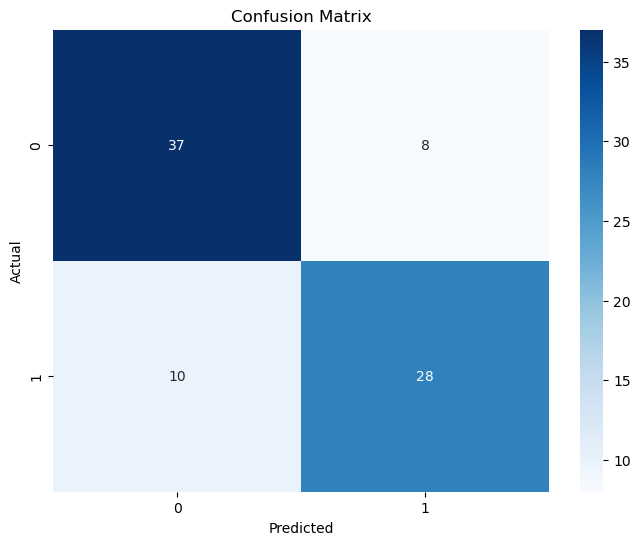

In [35]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## K Nearest Neighbours 

### Imports 

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline 
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

### Pipeline Definition 

In [11]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('knn', KNeighborsClassifier())  # KNN Classifier
])

In [12]:
param_grid_knn = {
    'knn__n_neighbors': list(range(3, 31, 2)),  # Odd numbers for n_neighbors
    'knn__weights': ['uniform', 'distance'],  # Weighting schemes
    'knn__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],  # Distance metrics
    'knn__p': [1, 2, 3]  # Minkowski metric parameter
}

In [14]:
grid_search_knn = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_knn,
    cv=5,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    refit='f1',  # Refitting the best model based on F1-score
    verbose=1,
    n_jobs=-1
)

In [15]:
grid_search_knn.fit(X_train, y_train)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


C:\Users\admin\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'minkowski',
                                         'chebyshev'],
                         'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19,
                                              21, 23, 25, 27, 29],
                         'knn__p': [1, 2, 3],
                         'knn__weights': ['uniform', 'distance']},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'],
             verbose=1)

In [17]:
best_model = grid_search_knn.best_estimator_
print(best_model)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(metric='manhattan', p=1))])


In [18]:
y_pred = best_model.predict(X_test)

### Metrics 

In [19]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79        45
           1       0.76      0.68      0.72        38

    accuracy                           0.76        83
   macro avg       0.76      0.75      0.75        83
weighted avg       0.76      0.76      0.76        83

Accuracy: 0.7590361445783133
Precision: 0.7594989803150175
Recall: 0.7590361445783133
F1 Score: 0.75746959469082


In [20]:
if len(np.unique(y)) == 2:
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.7944444444444444


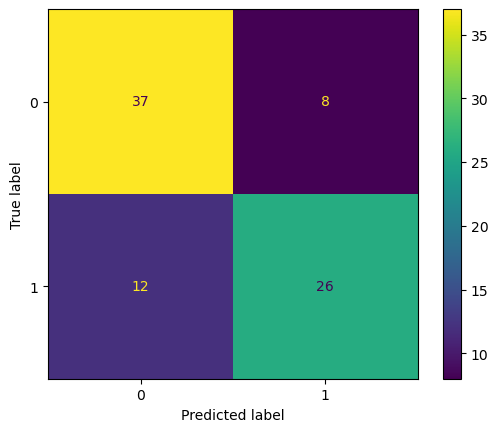

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

## Support Vector Machine Model 

In [22]:
from sklearn.svm import SVC
from scipy.spatial.distance import cdist 

In [23]:
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

In [24]:
param_grid_svm = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__kernel': ['linear', 'rbf', 'poly'],  
    'svm__degree': [2, 3, 4],  
    'svm__gamma': ['scale', 'auto', 0.1, 1]
}

In [25]:
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring='f1', n_jobs=-1, verbose=2)

In [27]:
grid_search_svm.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10, 100], 'svm__degree': [2, 3, 4],
                         'svm__gamma': ['scale', 'auto', 0.1, 1],
                         'svm__kernel': ['linear', 'rbf', 'poly']},
             scoring='f1', verbose=2)

In [33]:
grid_search_svm.best_params_

{'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}

In [30]:
grid_search_svm.best_score_

0.6676983300802429

In [32]:
best_model = grid_search_svm.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

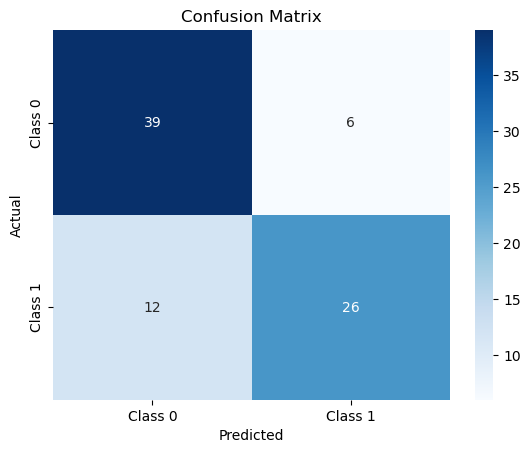

In [34]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

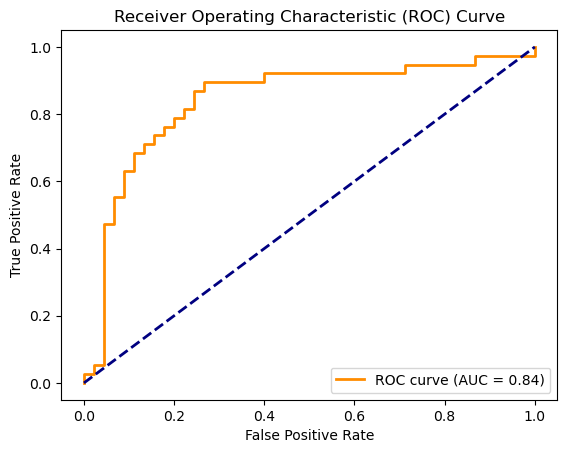

In [37]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()